In [25]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

true_beta = stats.norm.rvs(loc=0,scale=1,size=1)
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = stats.norm.rvs(loc=0,scale=1,size=100)
#y = stats.norm.rvs(loc=true_beta*x, scale=np.sqrt(1/true_phi))
#y = stats.norm.rvs(loc=true_beta*x, scale=true_phi)

y=np.random.normal(x*true_beta, np.sqrt(1/true_phi))

beta0 = stats.norm.rvs(loc=0,scale=1,size=1)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi,1/np.sqrt(true_phi))
print(theta0)

[ 0.32012389] [ 0.94339932] [ 1.02956132]
[-0.5212965   1.39630409]


In [32]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
def leapfrog(theta, r, eps):
    n = y.shape[0]
    gradients = np.array(theta[1]*(sum(x*y)-theta[0]*sum(x*x))-theta[0],((.5*n+a-1)/theta[1])-b-.5*sum((y-x*theta[0])*(y-x*theta[0])))
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [28]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=theta[0]*x, scale=1/np.sqrt(theta[1])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(1)) +gamma.logpdf(theta[1], a, scale=1/b)
    

In [29]:
def BuildTree(theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(theta,r,v*eps)
        if(np.linalg.norm(u) < np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            C_theta_prime = theta_prime
            C_r_prime = r_prime
        else:
            C_theta_prime = np.array([])
            C_r_prime = np.array([])
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,C_theta_prime,C_r_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree(theta,r,u,v,j-1,eps)
        if(v == -1):
            theta_minus,r_minus,dash1,dash2,C_theta_primep,C_r_primep,s_primep = BuildTree(theta_minus,r_minus,u,v,j-1,eps)
        else:
            dash1,dash2,theta_plus,r_plus,C_theta_primep,C_r_primep,s_primep = BuildTree(theta_plus,r_plus,u,v,j-1,eps)
        if((theta_plus-theta_minus).dot(r_minus) > 0 and (theta_plus-theta_minus).dot(r_plus) > 0):  
            s_prime = s_prime*s_primep  
        else:
            s_prime = 0  
        C_theta_prime = np.hstack([C_theta_prime,C_theta_primep])
        C_r_prime = np.hstack([C_r_prime,C_r_primep])
        return theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime

In [30]:
def hamilt_mc(theta0, y,x, eps, M):
    theta_m = np.zeros((M,2))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=2)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        C_theta = theta_m[m-1,:]
        C_r = r0
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,C_theta_prime,C_r_prime,s_prime = BuildTree(theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree(theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                C_theta = np.hstack([C_theta,C_theta_prime])
                C_r = np.hstack([C_r,C_r_prime]) 
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
        #print("C_Theta: ",C_theta)  
        index = np.random.randint(len(C_theta))
        if(index%2!=0):
            index = index-1    
        theta_m[m,:] = [C_theta[index],C_theta[index+1]]
        #print('This is the update: ',index,theta_m[m,:])
        #theta_m[m,:] = np.random.choice(C_theta,2)
        
        #r = np.random.choice(C_r,2)
        
        
    return(theta_m)

In [33]:
M = 1000
eps = .005
results = hamilt_mc(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
beta_found = np.mean(results[round(4*M/5):(M-1),0])
phi_found = np.mean(results[round(4*M/5):(M-1),1])
print("Mean after burn in we find",beta_found ,phi_found)
#print("acceptance (beta then phi)", acc_b/M, acc_p/M)

truth (array([ 0.32012389]), array([ 0.94339932]))
Mean after burn in we find 0.373485852023 0.917603503088


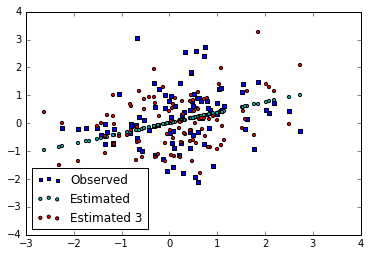

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

y_sim = stats.norm.rvs(loc=x*beta_found,scale=1/np.sqrt(phi_found))
#y_sim2 = stats.norm.rvs(loc=x*beta_found,scale=phi_found)
y_sim3 = np.random.normal(x*beta_found,phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x, y_sim, s=10, c='c', marker="o", label='Estimated')
#ax1.scatter(x, y_sim2, s=10, c='y', marker="o", label='Estimated 2')
ax1.scatter(x, y_sim3, s=10, c='r', marker="o", label='Estimated 3')
plt.legend(loc='lower left');
plt.show()


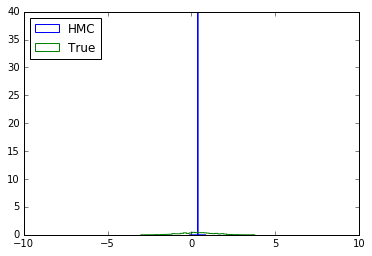

In [43]:


betas = stats.norm.rvs(true_beta,1, size=1000)
phis = stats.gamma.rvs(a=3,scale=1/2,size=1000)

plt.hist(beta_found, 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(betas, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([-10,10]);
plt.legend(loc='upper left')
pass

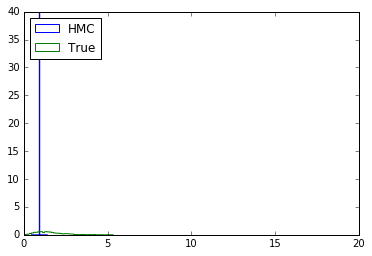

In [45]:
plt.hist(phi_found, 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(phis, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,20]);
plt.legend(loc='upper left')
pass

In [ ]:
a = np.array([1,2])
b = np.array([2,5])
np.hstack([a,b])

In [ ]:
r0 = stats.norm.rvs(size=2)
print(np.exp(log_joint(y,x,theta0)-(1/2)*r0.dot(r0)))
np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta0)-(1/2)*r0.dot(r0)))

In [ ]:
r0.dot(r0)

In [ ]:
log_joint(y,x,theta0)

In [ ]:
np.mean(results[:,0])

In [29]:
1/np.sqrt(3.38766997854)

0.54331219389021224